# Download the Data

In [1]:
!pip3 install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1

In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

In [4]:
train_annotations, _ = get_annotations('data/annotations/trainval.txt')
test_annotations, _ = get_annotations('data/annotations/test.txt')

In [5]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in test_annotations.items():
    all_annotations[key] = value

In [6]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [7]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5921
1428


# Visualize Data

In [8]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['Bombay', 'american_pit_bull_terrier', 'Maine_Coon', 'Ragdoll', 'British_Shorthair', 'newfoundland', 'keeshond', 'pug', 'american_bulldog', 'great_pyrenees', 'shiba_inu', 'boxer', 'pomeranian', 'Russian_Blue', 'beagle', 'havanese', 'Egyptian_Mau', 'chihuahua', 'Siamese', 'samoyed', 'english_cocker_spaniel', 'Bengal', 'leonberger', 'japanese_chin', 'Persian', 'german_shorthaired', 'basset_hound', 'saint_bernard', 'Abyssinian', 'staffordshire_bull_terrier', 'miniature_pinscher', 'scottish_terrier', 'Birman', 'yorkshire_terrier', 'Sphynx', 'english_setter', 'wheaten_terrier']

Num of classes: 37


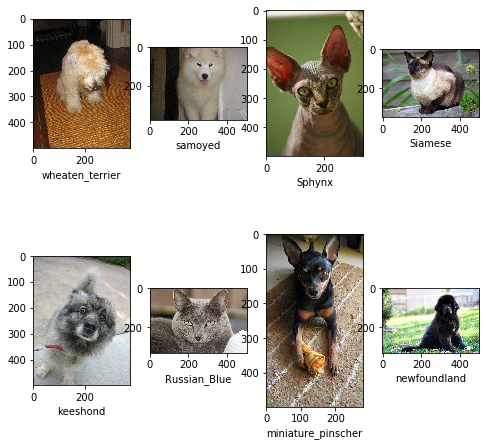

In [9]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [11]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'image-classification-000965729629'
training_image = get_image_uri(boto3.Session().region_name, 'image-classification', repo_version='latest')

print(training_image)


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


469771592824.dkr.ecr.ca-central-1.amazonaws.com/image-classification:latest


In [12]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [13]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [14]:
prepare_data(train_annotations, 'train')

100%|██████████| 5921/5921 [00:00<00:00, 7365.58it/s]


In [15]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1428/1428 [00:00<00:00, 7333.16it/s]


# Uploading Data to S3

In [16]:
%%time

s3_train_path = sagemaker_session.upload_data(path='train' , bucket=bucket, 
                                              key_prefix='train')
s3_train_lst_path = sagemaker_session.upload_data(path='train_lst' , bucket=bucket, 
                                                  key_prefix='train_lst')
s3_validation_path = sagemaker_session.upload_data(path='validation' , bucket=bucket, 
                                                   key_prefix='validation')
s3_validation_lst_path = sagemaker_session.upload_data(path='validation_lst' , bucket=bucket, 
                                                       key_prefix='validation_lst')


CPU times: user 37.3 s, sys: 3.16 s, total: 40.5 s
Wall time: 5min 35s


# SageMaker Estimator

In [20]:
train_instance_type='ml.p3.2xlarge'      # The type of EC2 instance which will be used for training
deploy_instance_type='ml.m4.xlarge'     # The type of EC2 instance which will be used for deployment

model = sagemaker.estimator.Estimator(
    training_image,            # Your entry script
    role=role,
    train_instance_count=1,                   # "The number of GPUs instances to use"
    train_instance_type='ml.p3.2xlarge',
    train_volume_size=100,
    train_max_run=900,
    input_mode='File',
    output_path='s3://{}/output'.format(bucket)
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


# Hyperparameters

In [22]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    num_classes=37,
    image_shape='3,224,224',
    mini_batch_size=32,
    resize=224,
    epochs = 10,
    learning_rate=0.001,
    num_training_samples=train_count,
    augmentation_type='crop_color_transform'
)

# Data Channels

In [23]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated',
                                       content_type='application/x-image', s3_data_type='S3Prefix')
train_lst_data = sagemaker.session.s3_input(s3_train_lst_path, distribution='FullyReplicated',
                                       content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                                       content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst_data = sagemaker.session.s3_input(s3_validation_lst_path, distribution='FullyReplicated',
                                       content_type='application/x-image', s3_data_type='S3Prefix')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [24]:
data_channels= {
    'train': train_data,
    'train_lst': train_lst_data,
    'validation': validation_data,
    'validation_lst': validation_lst_data
}

# Model Training

In [25]:
model.fit(inputs=data_channels, logs=True)

2020-10-08 23:05:12 Starting - Starting the training job...
2020-10-08 23:05:16 Starting - Launching requested ML instances......
2020-10-08 23:06:29 Starting - Preparing the instances for training......
2020-10-08 23:07:39 Downloading - Downloading input data......
2020-10-08 23:08:35 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[10/08/2020 23:08:58 INFO 139859041634112] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[10/08/2020 23:08:58 INFO 139859041634112] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'lea

[10/08/2020 23:10:00 INFO 139859041634112] Epoch[2] Batch [40]#011Speed: 746.331 samples/sec#011accuracy=0.484756
[10/08/2020 23:10:01 INFO 139859041634112] Epoch[2] Batch [60]#011Speed: 771.567 samples/sec#011accuracy=0.522541
[10/08/2020 23:10:01 INFO 139859041634112] Epoch[2] Batch [80]#011Speed: 754.267 samples/sec#011accuracy=0.570988
[10/08/2020 23:10:02 INFO 139859041634112] Epoch[2] Batch [100]#011Speed: 756.229 samples/sec#011accuracy=0.595606
[10/08/2020 23:10:03 INFO 139859041634112] Epoch[2] Batch [120]#011Speed: 757.295 samples/sec#011accuracy=0.594525
[10/08/2020 23:10:04 INFO 139859041634112] Epoch[2] Batch [140]#011Speed: 758.810 samples/sec#011accuracy=0.578679
[10/08/2020 23:10:05 INFO 139859041634112] Epoch[2] Batch [160]#011Speed: 758.258 samples/sec#011accuracy=0.576087
[10/08/2020 23:10:06 INFO 139859041634112] Epoch[2] Batch [180]#011Speed: 764.922 samples/sec#011accuracy=0.567680
[10/08/2020 23:10:06 INFO 139859041634112] Epoch[2] Train-accuracy=0.563007
[10/08/

[10/08/2020 23:10:50 INFO 139859041634112] Epoch[7] Batch [180]#011Speed: 778.359 samples/sec#011accuracy=0.893819
[10/08/2020 23:10:50 INFO 139859041634112] Epoch[7] Train-accuracy=0.892061
[10/08/2020 23:10:50 INFO 139859041634112] Epoch[7] Time cost=7.626
[10/08/2020 23:10:51 INFO 139859041634112] Epoch[7] Validation-accuracy=0.759943
[10/08/2020 23:10:51 INFO 139859041634112] Storing the best model with validation accuracy: 0.759943
[10/08/2020 23:10:51 INFO 139859041634112] Saved checkpoint to "/opt/ml/model/image-classification-0008.params"
[10/08/2020 23:10:52 INFO 139859041634112] Epoch[8] Batch [20]#011Speed: 767.990 samples/sec#011accuracy=0.904762
[10/08/2020 23:10:53 INFO 139859041634112] Epoch[8] Batch [40]#011Speed: 750.754 samples/sec#011accuracy=0.932165
[10/08/2020 23:10:54 INFO 139859041634112] Epoch[8] Batch [60]#011Speed: 764.284 samples/sec#011accuracy=0.928279
[10/08/2020 23:10:55 INFO 139859041634112] Epoch[8] Batch [80]#011Speed: 768.225 samples/sec#011accuracy=

# Deploy Model

In [26]:
deployed_model = model.deploy(initial_instance_count=1, instance_type=deploy_instance_type)
print('\n model deployed!')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!
 model deployed!


# Predictions

In [27]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1428


In [30]:
deployed_model.content_type = 'image/jpeg'

In [41]:
index = 2
image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)
results = json.loads(results)
print(results)

[2.7598278506957286e-07, 3.7659543750123703e-07, 1.3311209841049276e-05, 1.75678735558904e-06, 6.5849535531015135e-06, 0.00011158591223647818, 5.432944476524426e-07, 1.1148235898872372e-05, 0.001692850375548005, 6.036294053046731e-06, 4.356582394393627e-06, 0.0005322646466083825, 1.940270948352918e-07, 2.861972063783469e-07, 0.00014059888781048357, 1.1290738939351286e-06, 7.2027860369416885e-06, 1.176167870653444e-06, 3.9381782698910683e-05, 7.659932244052925e-09, 1.8483490293874638e-06, 1.2952507688623882e-07, 0.00018743309192359447, 0.00015903009625617415, 6.065926754672546e-06, 4.468792394618504e-05, 0.0015143804484978318, 0.9950369000434875, 2.3371883628442447e-07, 0.00022385019110515714, 7.367848411377054e-07, 2.6484556769901246e-08, 9.098065589796533e-08, 2.8343661142571364e-06, 1.2705122571787797e-05, 0.00021587556693702936, 2.209355625382159e-05]


In [42]:
classes[np.argmax(results)]

'saint_bernard'

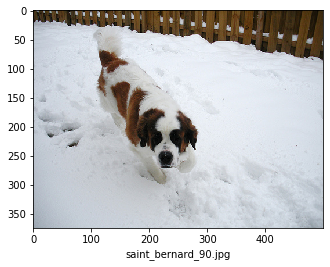

In [43]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)